## Imports and Dataframe Loading

In [1]:
import os, sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from data.data_helpers import get_dataframe

/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [16]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, LinearRegression  # or Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df = get_dataframe()
df.head()

/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Skipping existing file /Users/alfiehofmann/cis5200-project/data/era5_tehachapi_2018_H1.nc
Skipping existing file /Users/alfiehofmann/cis5200-project/data/era5_tehachapi_2018_H2.nc
Skipping existing file /Users/alfiehofmann/cis5200-project/data/era5_tehachapi_2019_H1.nc
Skipping existing file /Users/alfiehofmann/cis5200-project/data/era5_tehachapi_2019_H2.nc
Skipping existing file /Users/alfiehofmann/cis5200-project/data/era5_tehachapi_2020_H1.nc
Skipping existing file /Users/alfiehofmann/cis5200-project/data/era5_tehachapi_2020_H2.nc


,datetime,u10,v10,t2m,sp,hour_sin,hour_cos,month_sin,month_cos,doy_sin,doy_cos,wind_speed,target_next_hour
0,2018-01-01 00:00:00,-0.808231,-0.069685,291.890625,89925.2500,0.000000,1.000000,0.5,0.866025,0.017213,0.999852,0.811229,1.524293
1,2018-01-01 01:00:00,-1.340298,-0.725997,290.692627,89972.2500,0.258819,0.965926,0.5,0.866025,0.017213,0.999852,1.524293,1.245654
2,2018-01-01 02:00:00,-0.462882,-1.156458,288.544922,90036.1875,0.500000,0.866025,0.5,0.866025,0.017213,0.999852,1.245654,1.053555
3,2018-01-01 03:00:00,0.300817,-1.009697,285.121826,90091.3125,0.707107,0.707107,0.5,0.866025,0.017213,0.999852,1.053555,1.122294
4,2018-01-01 04:00:00,0.736362,-0.846944,283.715820,90125.1250,0.866025,0.500000,0.5,0.866025,0.017213,0.999852,1.122294,1.363163


## Simple Linear Regression w/ Train-Test Split

In [4]:
feature_cols = [c for c in df.columns if c not in ["datetime", "target_next_hour"]]
X = df[feature_cols]
y = df["target_next_hour"]

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [11]:
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 0.17212836359121614
RMSE: 0.4148835542549453
MAE: 0.29745161946434084
R²: 0.9027265739919468


/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


## Adding Complexity: Cross-Validation, Scaling, and Ridge

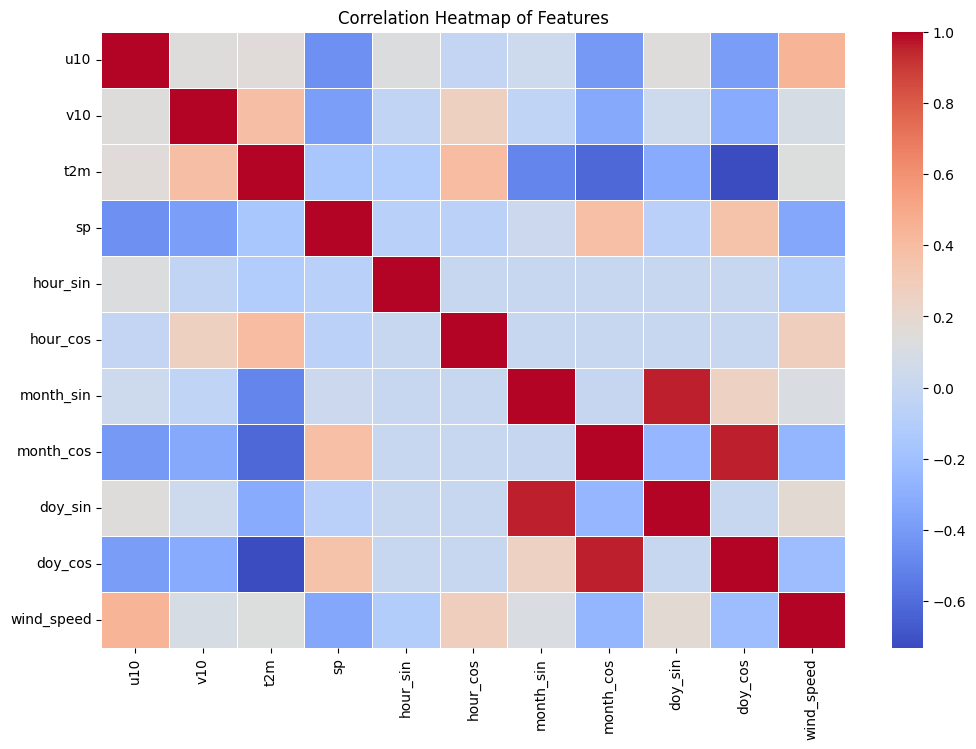

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=False, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap of Features")
plt.show()

In [18]:
corr_matrix = X.corr()
print(corr_matrix)

                 u10       v10       t2m        sp      hour_sin  \
u10         1.000000  0.146788  0.156607 -0.451165  1.248596e-01   
v10         0.146788  1.000000  0.387883 -0.379317 -2.772062e-02   
t2m         0.156607  0.387883  1.000000 -0.158552 -1.143286e-01   
sp         -0.451165 -0.379317 -0.158552  1.000000 -7.516627e-02   
hour_sin    0.124860 -0.027721 -0.114329 -0.075166  1.000000e+00   
hour_cos   -0.019050  0.268324  0.404791 -0.066745  1.900996e-05   
month_sin   0.038076 -0.034959 -0.493927  0.022479  9.041932e-08   
month_cos  -0.408438 -0.326481 -0.615352  0.379138  1.968247e-05   
doy_sin     0.147285  0.039439 -0.323910 -0.073942  3.386018e-07   
doy_cos    -0.388606 -0.319794 -0.730225  0.359078  1.965080e-05   
wind_speed  0.443837  0.092850  0.133328 -0.341826 -1.039829e-01   

                hour_cos     month_sin  month_cos       doy_sin   doy_cos  \
u10        -1.904959e-02  3.807646e-02  -0.408438  1.472851e-01 -0.388606   
v10         2.683240e-01 -3.4

In [12]:
# Time-series aware CV (no shuffling/leakage)
tscv = TimeSeriesSplit(n_splits=5)

# Pipeline: polynomial features -> scaling -> Ridge regression
pipe = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

# Hyperparameters to tune
param_grid = {
    "poly__degree": [1, 2],
    "ridge__alpha": [0.1, 1.0, 10.0]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV RMSE:", (-grid.best_score_) ** 0.5)

best_model = grid.best_estimator_

/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/alfiehofman

Best params: {'poly__degree': 2, 'ridge__alpha': 10.0}
Best CV RMSE: 0.40839572446742706


In [13]:
# 80% of the earliest data for training, last 20% for testing
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Test RMSE:", mean_squared_error(y_test, y_pred))
print("Test R²:", r2_score(y_test, y_pred))

Test RMSE: 0.13797807720312907
Test R²: 0.9220256324784061


/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alfiehofmann/cis5200-project/venv/lib/python3.9/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid

## Visualizations

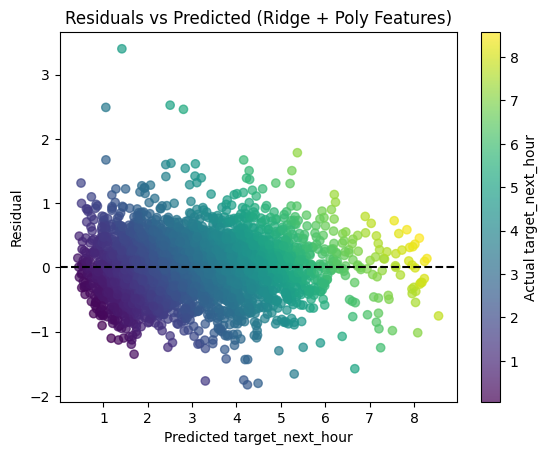

In [14]:
residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals, c=y_test, cmap='viridis', alpha=0.7)
plt.axhline(0, linestyle="--", color="black")
plt.colorbar(label="Actual target_next_hour")
plt.xlabel("Predicted target_next_hour")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted (Ridge + Poly Features)")
plt.show()
